In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import holidays
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from weather_tools import state_years
from energy_tools import read_region

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
def df_to_features(df, degree, temp_column='MEAN_T'):
    """Converts df to features for regression model
    
    Assumes df index is datetime
    
    New dataframe has T, T^2...T^degree
    Also one-hot encodes the day
    """
    
    us_holidays = holidays.US()
    
    X_df = pd.DataFrame(index = df.index)
    for i in list(range(1, degree + 1)):
        X_df[f'T_{i}'] = df[temp_column]**i
    # add day of week
    X_df = pd.concat((X_df, pd.get_dummies(df.index.dayofweek, prefix='day').set_index(df.index)), 
                   axis=1)
    # add month of year
    X_df = pd.concat((X_df, pd.get_dummies(df.index.month, prefix='month').set_index(df.index)), 
                   axis=1)
    # add holidays
    is_holiday = pd.Series(np.zeros(len(X_df)), index=X_df.index, name='Holiday')
    is_holiday.loc[us_holidays[X_df.index[0]:X_df.index[-1]]] = 1
    X_df = pd.concat((X_df, is_holiday), axis=1)
    
    
    return X_df

In [3]:
def up_to_degree(df, degree):
    """Return only columns of df up to degree
    
    Columns of the form T_1, T_2, ... T_n
    """
    
    return df[[col for col in X.columns
                  if (col.startswith('T_') and int(col[2:]) <= degree)
                  or not col.startswith('T_')]]

# What does energy demand depend on?
## Loading in data

In [4]:
df_NY_temperature = pd.read_csv('state_data/NY_2015-2019_raw.csv', 
                                index_col=['DATE'], parse_dates=['DATE'])

In [5]:
df_NY_temperature.head()

,MEAN_T
DATE,
2015-01-01,22.769231
2015-01-02,28.153846
2015-01-03,31.250000
2015-01-04,30.416667
2015-01-05,44.384615


In [6]:
df_NY_energy = read_region('New York')

In [7]:
df_NY_energy.head()

Forecast   Demand
Date       Hour                   
2015-07-01 1      16045.0  16891.0
           2          0.0  16027.0
           3          0.0  15541.0
           4          0.0  15283.0
           5          0.0  15304.0

In [8]:
rolling_mean = df_NY_energy.groupby(level=0)['Demand'].sum().rolling(7, win_type='boxcar').mean()

In [9]:
rolling_mean.head(10)

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
2015-07-06              NaN
2015-07-07    465424.428571
2015-07-08    473463.000000
2015-07-09    477186.142857
2015-07-10    487240.142857
Name: Demand, dtype: float64

In [10]:
rolling_mean.index[183]

Timestamp('2015-12-31 00:00:00')

## Exploratory analysis

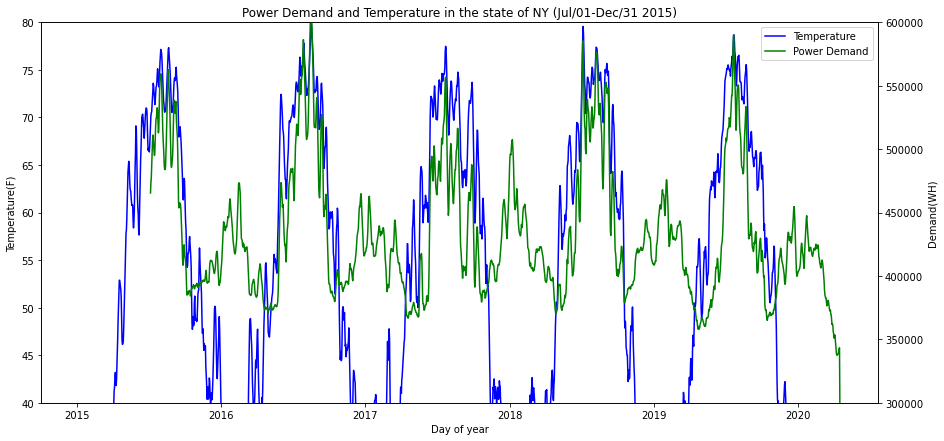

In [11]:
fig,ax1 =plt.subplots()
fig.set_size_inches(15, 7)

ax2 = ax1.twinx()

line1, =ax1.plot(df_NY_temperature.index, df_NY_temperature['MEAN_T'].rolling(7, win_type='boxcar').mean().values,'b-', label = 'Temperature')
line2, =ax2.plot(rolling_mean.index,rolling_mean.values,'g-', label = 'Power Demand')

lines = [line1, line2]

ax1.legend(lines, [l.get_label() for l in lines])

ax1.set_ylim(40,80)
ax2.set_ylim(300000,600000)

ax1.set_xlabel('Day of year')
ax1.set_ylabel('Temperature(F)')
ax2.set_ylabel('Demand(WH)')

ax1.set_title('Power Demand and Temperature in the state of NY (Jul/01-Dec/31 2015)')

plt.show()

### Temperature and weekday seem to be a good predictor

NB: We'll train later only on <=2019 data, so predictions for 2020 aren't biased

In [12]:
past_temperatures = df_NY_temperature.loc[df_NY_temperature.index.year <= 2019]

Text(0, 0.5, 'Demand - Mean Demand [GWh]')

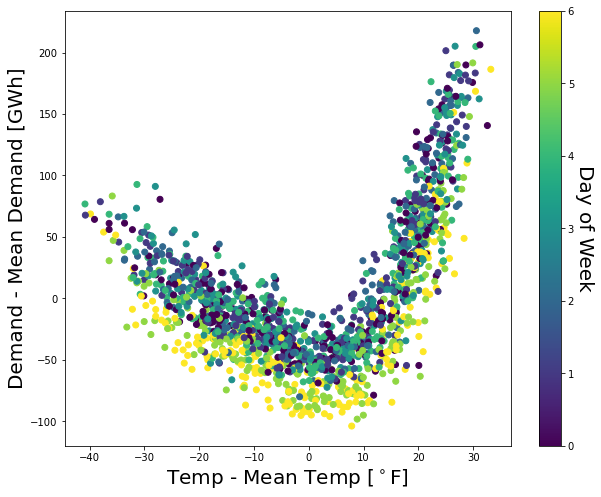

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 8)

temp_to_mean = past_temperatures - past_temperatures.mean()
demand_to_mean = df_NY_energy['Demand'].groupby('Date').sum(min_count=24) - df_NY_energy['Demand'].mean() * 24



day_locs = demand_to_mean.index.intersection(temp_to_mean.index)
im = ax.scatter(temp_to_mean.loc[day_locs], demand_to_mean.loc[day_locs] / 1.e3,
           c=day_locs.dayofweek)

cbar = fig.colorbar(im)
cbar.set_label('Day of Week', fontsize=20, rotation=270, labelpad=20)

ax.set_xlabel('Temp - Mean Temp [${}^\circ$F]', fontsize=20)
ax.set_ylabel('Demand - Mean Demand [GWh]', fontsize=20)

What other features may play a role? Below, we see that beyond just day of week, month may matter, even if it overlaps heavily with temperature.

In [14]:
plot_df = temp_to_mean.loc[day_locs, ['MEAN_T']].copy()
plot_df['Month'] = day_locs.month
plot_df['Day'] = day_locs.dayofweek
plot_df['Demand'] = demand_to_mean.loc[day_locs]

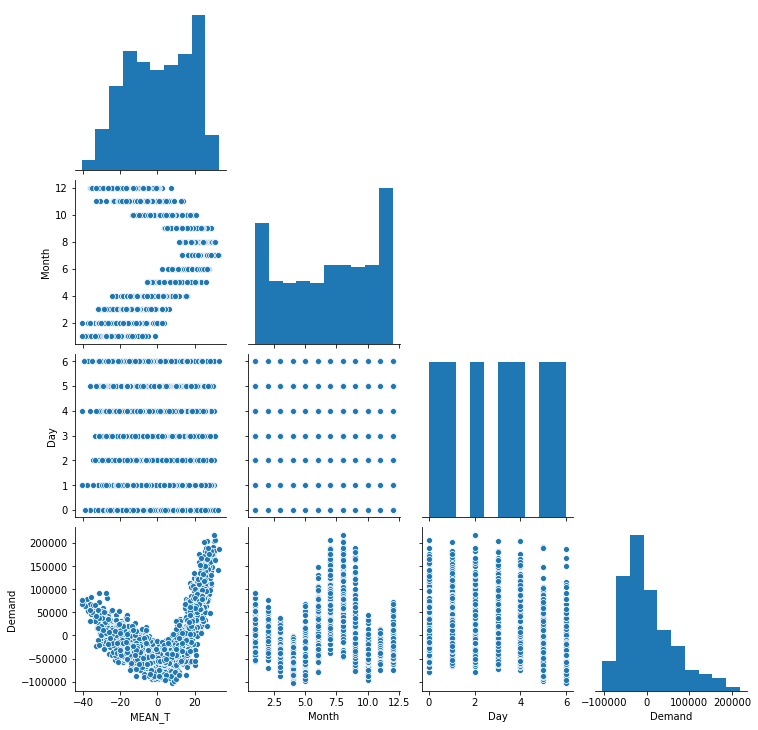

In [15]:
sns.pairplot(plot_df, corner=True)

## Building a regression model to predict demand

Setting up features: let's use a polyomial of temperature, as well as day of week.

We'll one hot encode the day of week.

In [16]:
# get rid of nan values
day_locs = demand_to_mean.index.intersection(temp_to_mean.index)
day_locs = day_locs[(~df_NY_energy['Demand'].groupby('Date').sum(min_count=24).loc[day_locs].isna()).values
                                    & (~df_NY_temperature.loc[day_locs].isna()).values.flatten()]

y = df_NY_energy['Demand'].groupby('Date').sum(min_count=24).loc[day_locs].copy()

X_df = df_to_features(df_NY_temperature.loc[day_locs], 9)

In [17]:
temp_columns = [col for col in X_df.columns if col.startswith('T_')]
categorical_columns = [col for col in X_df.columns if (col.startswith('day') 
                                                       or col.startswith('month') 
                                                       or col.startswith('Holiday'))]

In [18]:
scaler = StandardScaler()
X = X_df.copy()
X[temp_columns] = scaler.fit_transform(X_df[temp_columns])

### First we'll determine the best model hyperparameters 

Now, we'll do a grid search over regularization parameters, as well as loop over different degree polynomials

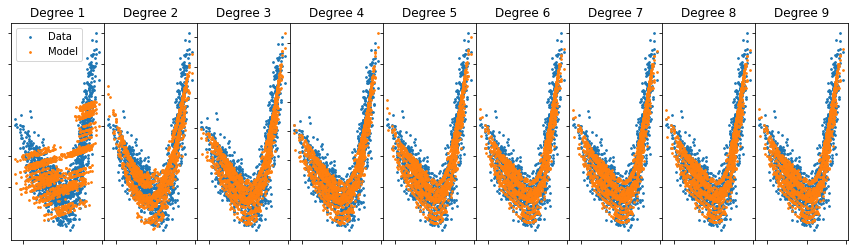

In [19]:
# Using CV to test best polynomial degree and best regularization parameter

degree_score = np.zeros(len(temp_columns))
degree_alpha = np.zeros(len(temp_columns))
degree_list = np.array(list(map(lambda x: int(x[2:]), temp_columns)))

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

best_models = []

fig, ax = plt.subplots(1, len(degree_list))
fig.set_size_inches(15, 4)
fig.subplots_adjust(wspace=0)

for it, degree in enumerate(degree_list):

    Xtrain_deg = up_to_degree(Xtrain, degree)
    
    model = Ridge()

    grid = GridSearchCV(model, param_grid={'alpha': np.logspace(-6, 2, 100)}, )

    grid.fit(Xtrain_deg, ytrain)

    ax[it].set_xticklabels([], [])
    ax[it].set_yticklabels([], [])
    ax[it].set_title(f'Degree {degree}')
    ax[it].scatter(Xtrain.loc[:, 'T_1'], 
                  ytrain, s=3, label='Data')

    ax[it].scatter(Xtrain.loc[:, 'T_1'],
                  grid.best_estimator_.predict(Xtrain_deg), s=3,
                  label='Model')
    
    degree_score[it] = grid.best_score_
    degree_alpha[it] = grid.best_params_['alpha']
    
    best_models.append(grid.best_estimator_)

ax[0].legend(loc='upper left')

The best model is formally a pretty high degree polynomial, with a very small regularization parameter. However, as we'll see in more detail, you don't need to go that high for a good fit. Glancing over the plots above, you can see that by degree $\approx3$, we fit the model as well as we can.

In [20]:
print(f'Best model is degree {degree_list[np.argmax(degree_score)]}')
print(f'Best alpha is {degree_alpha[np.argmax(degree_score)]}')

Best model is degree 6
Best alpha is 1e-06


In [21]:
best_models[np.argmax(degree_score)].score(up_to_degree(Xtest, 
                                                        degree_list[np.argmax(degree_score)]), 
                                                        ytest)

0.8855043914577045

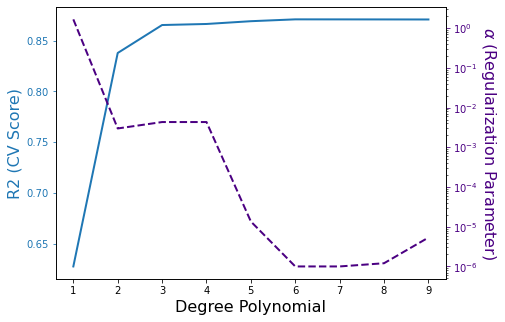

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
ax.plot(degree_list, degree_score, 
        lw=2)
ax.set_xlabel('Degree Polynomial', fontsize=16)
ax.set_ylabel('R2 (CV Score)', fontsize=16, color='C0')
ax.yaxis.set_tick_params(color='C0', labelcolor='C0')
ax2 = ax.twinx()
ax2.plot(degree_list, degree_alpha, color='indigo', 
         ls='--', lw=2)
ax2.tick_params(color='indigo', labelcolor='indigo')
ax2.set_ylabel(r'$\alpha$ (Regularization Parameter)', fontsize=16, 
               rotation=270, labelpad=20, color='indigo')
ax2.set_yscale('log')

Based on this above plot, though, in reality, once we hit degree 3 or 4, we more or less fit as well as possible. Interestingly, we don't ever seem to have a turnover in our performance as a result of overfitting. You can see the same thing in the above plots.

### Let's pick a model

We'll pick the 4th degree polynomial as our fiducial linear regression model.

In [23]:
reg = best_models[np.where(degree_list == 4)[0][0]]

It has a pretty high R2 score on our test set (recall, the R2 vs degree plot above is the cross-validation set), for picking hyperparameters).

In [24]:
reg.score(up_to_degree(Xtest, 4), ytest)

0.8805111680444588

Now, instead of data up to 2019, we'll incorporate our full data set including 2020.

In [25]:
all_data = pd.concat((df_to_features(df_NY_temperature, 4), 
                      df_to_features(pd.read_csv('state_data/NY_2020_raw.csv', 
                                index_col=['DATE'], parse_dates=['DATE']), 4)), 
                     axis=0)

In [26]:
all_data = all_data.dropna()

In [27]:
temp_columns = [col for col in all_data if col.startswith('T_')]
all_data_transform = all_data.copy()
all_data_transform[temp_columns] = scaler.fit_transform(all_data[temp_columns])

In [29]:
# there are some nans we want to get rid of for later
daily_energy = df_NY_energy.groupby('Date').sum(min_count=24)
daily_energy = daily_energy.dropna()

# ensure we have indexes that are common to all data
my_locs = demand_to_mean.index.intersection(all_data_transform.index)
my_locs = daily_energy.index.intersection(my_locs)

In [30]:
pred = pd.DataFrame(index=my_locs, 
                    data=reg.predict(all_data_transform.loc[my_locs]), 
                    columns=['D_Pred'])
pred_average = pred.rolling(7, win_type='gaussian', center=True).mean(std=2)

In [31]:
daily_average = daily_energy.rolling(7, win_type='gaussian', center=True).mean(std=2)

### How does it perform?

We note again here that the model was fit only on 2015-2019 data.

The vertical line shows Febuary 29th, the date of the first (known) US death from COVID-19, and the day Washington became the first US State to declare a state of emergency.

(-15.0, 12.0)

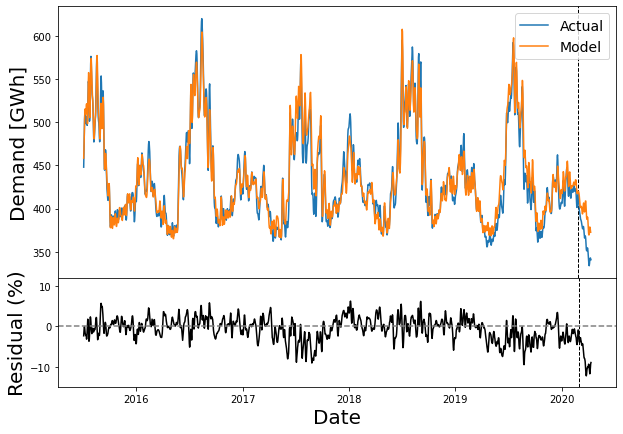

In [32]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[5, 2]})
fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)

residuals = 100 * (1 - pred_average['D_Pred'] / daily_average['Demand'])

ax[0].plot(daily_average.index, 
        daily_average['Demand']/1.e3, label = 'Actual')
ax[0].plot(pred_average.index, pred_average['D_Pred']/1.e3, label='Model')
ax[1].plot(daily_average.index, 
           residuals, color='black')
ax[1].axhline(0, color='grey', ls='--')

for i in [0, 1]:
    ax[i].axvline('20200229', color='k', ls='--', zorder=0, lw=1)


ax[0].legend(loc='best', fontsize=14)

ax[1].set_xlabel('Date', fontsize=20)
ax[0].set_ylabel('Demand [GWh]', fontsize=20)
ax[1].set_ylabel('Residual (%)', fontsize=20)
ax[1].set_ylim([-15, 12])
